In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [3]:
# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text 

In [6]:
# Read dataset & Preprocess text

df_train = pd.read_csv('/content/drive/MyDrive/nlp_project/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/nlp_project/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/nlp_project/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [7]:
df_train.sample(5)

,Text,Emotion
10015,i do feel lonely at times and at times i still...,sadness
6437,ive been feeling like i cant put a lot into th...,love
3184,i am afraid that once again i will feel hopele...,sadness
12899,i feel myself caring and wondering more than them,love
2539,i am feeling manipulkated and wronged by my so...,anger


In [8]:
df_train.describe()

,Text,Emotion
count,16000,16000
unique,15969,6
top,i feel more adventurous willing to take risks ...,joy
freq,2,5362


In [9]:
df_test.describe()

,Text,Emotion
count,2000,2000
unique,2000,6
top,im really not taking in information lately it ...,joy
freq,1,695


In [10]:
df_val.describe()

,Text,Emotion
count,2000,2000
unique,1998,6
top,i feel so tortured by it,joy
freq,2,704


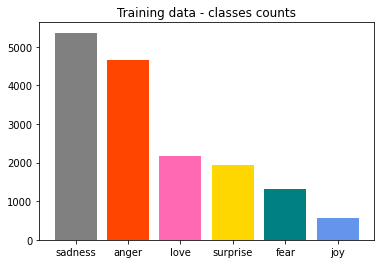

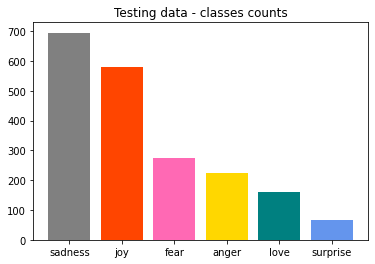

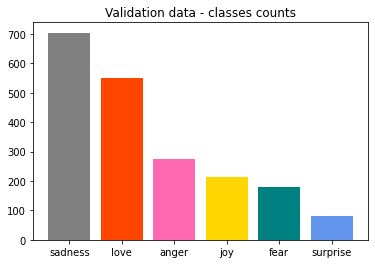

In [11]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [12]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


In [13]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 15213


In [14]:
path_to_glove_file = '/content/drive/MyDrive/nlp_project/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 14212 words (1000 misses)


In [15]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3042600   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [20]:
# Building model(fit) and providing test data for validation
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10
                  
                   )

Epoch 1/10
63/63 [==============================] - 562s 9s/step - loss: 1.5598 - accuracy: 0.3695 - val_loss: 1.2736 - val_accuracy: 0.5325
Epoch 2/10
63/63 [==============================] - 548s 9s/step - loss: 1.1521 - accuracy: 0.5696 - val_loss: 0.8588 - val_accuracy: 0.6825
Epoch 3/10
63/63 [==============================] - 546s 9s/step - loss: 0.7080 - accuracy: 0.7402 - val_loss: 0.4515 - val_accuracy: 0.8270
Epoch 4/10
63/63 [==============================] - 546s 9s/step - loss: 0.3467 - accuracy: 0.8721 - val_loss: 0.2603 - val_accuracy: 0.9020
Epoch 5/10
63/63 [==============================] - 544s 9s/step - loss: 0.2276 - accuracy: 0.9131 - val_loss: 0.1973 - val_accuracy: 0.9215
Epoch 6/10
63/63 [==============================] - 540s 9s/step - loss: 0.1598 - accuracy: 0.9300 - val_loss: 0.1649 - val_accuracy: 0.9190
Epoch 7/10
63/63 [==============================] - 539s 9s/step - loss: 0.1302 - accuracy: 0.9401 - val_loss: 0.1587 - val_accuracy: 0.9245
Epoch 8/10
63

In [21]:
# Evaluating the model with validation data set

model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 62s 989ms/step - loss: 0.1417 - accuracy: 0.9330


[0.14173798263072968, 0.9330000281333923]

In [22]:
# data parameters of built model 

print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


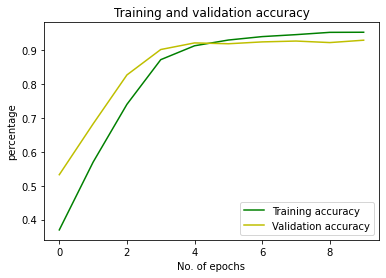

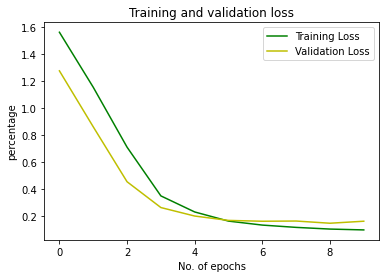

In [23]:
# graph representation of accuracy and loss of train and test data 

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("percentage")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'y', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("No. of epochs")
plt.ylabel("percentage")
plt.legend()

plt.show()

In [18]:
sentences = [
             "He is over the moon about being accepted to the university",
             "Your point on this certain matter made me outrageous, how can you say so?",
             "i happy you",
             "WorldAIDSDay END INEQUALITIES. END AIDS. END PANDEMICS"
]

for sentence in sentences:
  print(sentence)
  sentence = clean(sentence)
  sentence = tokenizer.texts_to_sequences([sentence])
  sentence = pad_sequences(sentence,maxlen=256, truncating='pre')
  result = le.inverse_transform(np.argmax(model.predict(sentence),axis=-1))[0]
  proba = np.max(model.predict(sentence))
  print(f"{result}: {proba}\n\n")

He is over the moon about being accepted to the university
joy: 0.9865525364875793


Your point on this certain matter made me outrageous, how can you say so?
anger: 0.5193082690238953


i happy you
joy: 0.8218266367912292


WorldAIDSDay END INEQUALITIES. END AIDS. END PANDEMICS
fear: 0.48391082882881165




In [17]:
# Saving the model     
    
model.save('/content/drive/MyDrive/nlp_project/Emotion_Recognition.h5')

In [18]:
from keras.models import load_model

storedModel = load_model('/content/drive/MyDrive/nlp_project/Emotion_Recognition.h5')

In [21]:
storedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3042600   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

## Fetching Tweets SECTION

In [23]:
# importing packages

import tweepy
import pandas as pd

In [24]:
# Api and Secret keys

api_key = "LeRJxmWPxG0dBcPoDThRqmAoB"
api_key_secret = "OUpsJV4oMmcBxVZ7sSkXhrPyxhxo6PzEAZQhrnhkk7b9x0mKHt"

access_token = "3482308459-o1cw43udRKgLuU5hb1QJ8DnlMcDvPOYKxrKTCe5"
access_token_secret = "yIboNQP1gqljX6ZHnETmKwBKq3V5eIWVPUGnYwIoTT0IU"

In [25]:
# Accessing API 

auth = tweepy.OAuthHandler(consumer_key=api_key, consumer_secret=api_key_secret)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth)


In [26]:
print(api)

In [27]:
# For GeoLocation

woeid=23424748  # Taking Austrial as location

In [28]:
# Accessing trends topic of particular geolocation

trend_result = api.trends_place(woeid)

In [29]:
# Displaying top 10 trending list

for trend in trend_result[0]["trends"][:10]:
  print(trend['name'])

#SpotifyWrapped
#IDPwD
#MUNARS
Tudge
#QandA
Arsenal
Auba
De Gea
#PitMad
Carrick


In [30]:
trends = trend_result[0]["trends"][:1]

top = trends[0]['name']

In [31]:
top

'#SpotifyWrapped'

In [32]:
# Setting filtering word

search_words = top + " -filter:retweets"

In [33]:
# pulling tweets 

tweets = tweepy.Cursor(api.search, 
                           q=search_words,
                           lang="en").items(1000)

users_tweets = [[tweet.text] for tweet in tweets]

In [34]:
# storing data into pandas DataFrame

df = pd.DataFrame(data=users_tweets,columns=["Tweet"])

In [35]:
df

,Tweet
0,"To my #1 podcast of 2021, ASMR Therapy.: thank..."
1,So about #SpotifyWrapped - why can I not searc...
2,Thank you Moshiach Oi! for spending 261 minute...
3,tis the season to listen to my #SpotifyWrapped...
4,To be honest I don't know how Lil Wayne and As...
...,...
995,"Thank you @yungblud for spending 6,686 minutes..."
996,"To my #1 podcast of 2021, Love Letters: thank ..."
997,"I spent a total of 20,720 minutes listening to..."
998,Can't say this shocks me at all. Top 3 songs a...


In [36]:
import re


In [37]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [38]:
def text_cleaning(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)     # removing @mentions
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # removing @mentions 
  text = re.sub(r'@[A-Za-z]+', '', text)        # removing @mentions
  text = re.sub(r'@[-)]+', '', text)            # removing @mentions
  text = re.sub(r'#', '', text )                # removing '#' sign
  text = re.sub(r'RT[\s]+', '', text)           # removing RT
  text = re.sub(r'https\S+', '', text)          # removing https:
  text = re.sub(r'https?\/\/\S+', '', text)     # removing the hyper link
  text = re.sub(r'&[a-z;]+', '', text)          # removing '&gt;'
  text = re.sub(r'\n', '',text )                # removing '\n'
  text = re.sub(r',', '',text)                  # removing ","
  text = re.sub(r'\"','',text)                   # removing " \" "
  text = re.sub(r'\d','',text)                  # removing numbers
  
  return remove_emojis(text)

In [39]:
# cleaning tweets

df['tweet_clean'] = df['Tweet'].map(lambda x: text_cleaning(x))

In [40]:
df

,Tweet,tweet_clean
0,"To my #1 podcast of 2021, ASMR Therapy.: thank...",To my podcast of ASMR Therapy.: thank you fo...
1,So about #SpotifyWrapped - why can I not searc...,So about SpotifyWrapped - why can I not search...
2,Thank you Moshiach Oi! for spending 261 minute...,Thank you Moshiach Oi! for spending minutes w...
3,tis the season to listen to my #SpotifyWrapped...,tis the season to listen to my SpotifyWrapped ...
4,To be honest I don't know how Lil Wayne and As...,To be honest I don't know how Lil Wayne and As...
...,...,...
995,"Thank you @yungblud for spending 6,686 minutes...",Thank you for spending minutes with me this ...
996,"To my #1 podcast of 2021, Love Letters: thank ...",To my podcast of Love Letters: thank you for...
997,"I spent a total of 20,720 minutes listening to...",I spent a total of minutes listening to Lemon...
998,Can't say this shocks me at all. Top 3 songs a...,Can't say this shocks me at all. Top songs ar...


In [41]:
df['tweet_clean']

0      To my  podcast of  ASMR Therapy.: thank you fo...
1      So about SpotifyWrapped - why can I not search...
2      Thank you Moshiach Oi! for spending  minutes w...
3      tis the season to listen to my SpotifyWrapped ...
4      To be honest I don't know how Lil Wayne and As...
                             ...                        
995    Thank you  for spending  minutes with me this ...
996    To my  podcast of  Love Letters: thank you for...
997    I spent a total of  minutes listening to Lemon...
998    Can't say this shocks me at all. Top  songs ar...
999    Thank you  for spending  minutes with me this ...
Name: tweet_clean, Length: 1000, dtype: object

In [42]:
df

,Tweet,tweet_clean
0,"To my #1 podcast of 2021, ASMR Therapy.: thank...",To my podcast of ASMR Therapy.: thank you fo...
1,So about #SpotifyWrapped - why can I not searc...,So about SpotifyWrapped - why can I not search...
2,Thank you Moshiach Oi! for spending 261 minute...,Thank you Moshiach Oi! for spending minutes w...
3,tis the season to listen to my #SpotifyWrapped...,tis the season to listen to my SpotifyWrapped ...
4,To be honest I don't know how Lil Wayne and As...,To be honest I don't know how Lil Wayne and As...
...,...,...
995,"Thank you @yungblud for spending 6,686 minutes...",Thank you for spending minutes with me this ...
996,"To my #1 podcast of 2021, Love Letters: thank ...",To my podcast of Love Letters: thank you for...
997,"I spent a total of 20,720 minutes listening to...",I spent a total of minutes listening to Lemon...
998,Can't say this shocks me at all. Top 3 songs a...,Can't say this shocks me at all. Top songs ar...


In [43]:
result_list = []
proba_list = []


for sentence in df['tweet_clean']:
  sentence = clean(sentence)
  sentence = tokenizer.texts_to_sequences([sentence])
  sentence = pad_sequences(sentence,maxlen=256, truncating='pre')
  result = le.inverse_transform(np.argmax(storedModel.predict(sentence),axis=-1))[0]
  proba = np.max(storedModel.predict(sentence))
  result_list.append(result)
  proba_list.append(proba)

In [44]:
df['predicted_emotion'] = result_list
df['probability'] = proba_list

In [45]:
df

,Tweet,tweet_clean,predicted_emotion,probability
0,"To my #1 podcast of 2021, ASMR Therapy.: thank...",To my podcast of ASMR Therapy.: thank you fo...,joy,0.395654
1,So about #SpotifyWrapped - why can I not searc...,So about SpotifyWrapped - why can I not search...,joy,0.523200
2,Thank you Moshiach Oi! for spending 261 minute...,Thank you Moshiach Oi! for spending minutes w...,anger,0.353740
3,tis the season to listen to my #SpotifyWrapped...,tis the season to listen to my SpotifyWrapped ...,joy,0.533431
4,To be honest I don't know how Lil Wayne and As...,To be honest I don't know how Lil Wayne and As...,fear,0.632899
...,...,...,...,...
995,"Thank you @yungblud for spending 6,686 minutes...",Thank you for spending minutes with me this ...,anger,0.353740
996,"To my #1 podcast of 2021, Love Letters: thank ...",To my podcast of Love Letters: thank you for...,joy,0.402875
997,"I spent a total of 20,720 minutes listening to...",I spent a total of minutes listening to Lemon...,anger,0.324238
998,Can't say this shocks me at all. Top 3 songs a...,Can't say this shocks me at all. Top songs ar...,anger,0.396442


In [46]:
df['predicted_emotion'].value_counts()

anger       390
joy         324
fear        276
surprise      6
love          2
sadness       2
Name: predicted_emotion, dtype: int64

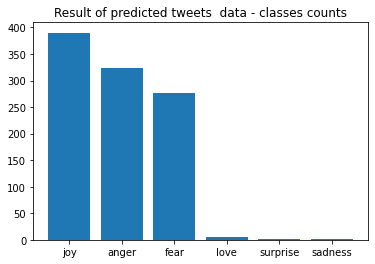

In [47]:
plt.bar(df['predicted_emotion'].unique(),height=df['predicted_emotion'].value_counts())
plt.title("Result of predicted tweets  data - classes counts")
plt.show()

So, As per the result obtained we can say that people are anger regarding "#SpotifyWrapped" 